# Working with Gaussians

## Estimating unobserved data

In this live script, we will be working with temperature data in Boston. We will use the concepts explored in this section to create estimates of unobserved data using Gaussian processes.

### The Data (Avalilable in https://www.usclimatedata.com/)

Initially, lets load the data available for this example. We have two data sets

1. Weather information in Boston in the forms of averages from 1981 to 2010. We are provided with average high and low temperature precipitation and inches of snow for every day of the year.
2. Weather information in Boston in 2019. We are provided with average high and low temperature precipitation and inches of snow for every day of the year.

For simplicity we are going to work with the temperature information only.
The provided file 'data.mat' consis of 4 columns and 365 rows. Each row indicates a consecutuve day of the year.

- Column 1 is the highest recorded temperature in Boston in 2019 in a particular day.
- Column 2 is the lowest recorded temperature in Boston in 2019 in a particular day.
- Column 3 is the average of the highest recorded temperatures in Boston from 1981 to 2010 in a particular day.
- Column 4 is the average of the lowest recorded temperature in Boston from 1981 to 2010 in a particular day.

Load the average data


In [1]:
import scipy.io
d = scipy.io.loadmat("data.mat")
data = d['data'].T

Let's see how the data looks like


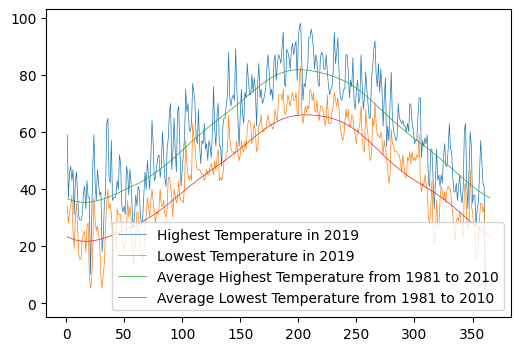

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams['figure.dpi'] = 100

x = np.arange(1, 366)
for i, label in enumerate(
    [
        "Highest Temperature in 2019",
        "Lowest Temperature in 2019",
        "Average Highest Temperature from 1981 to 2010",
        "Average Lowest Temperature from 1981 to 2010"
    ]
):
    plt.plot(x, data[i], label=label, lw=0.5)
plt.legend()
plt.show()

**Note: Temperature information is missing for the last 5 days of 2019. Entries have been filled with zeros, but this does not mean the temperature is zero.**


## The Model

For simplicity we are going to work with the highest temperature of the day variable. The process for the lowest temperature, or the amout of snow or precipitaion follow a similar principle.

We have model the temperature for each day as a Gaussian random variable. We have will use the average data infomation as surrogate for the mean of the random variables. We will consider the temperature data in 2019 as the observations of those random variables.

For instructional purposes lets assume we only have measurements in 2019 once every 4 days. Thus we define

- $\mathbf{X}_1$: Multivariate Gaussian random variable. Temperature in Boston for the days we do not have observations: Day 2, Day 3, Day 4 Day 6, ....
- $\mathbf{X}_2$: Multivariate Gaussian random varibale. Temperature in Boston for the days we have observations. Day 1, Day 5, Day 9.......
- $\mathbf{x}_2$: Observations of $\mathbf{X}_2$.
- $\mu_1$: Mean of $\mathbf{X}_1$: Column 3 in the data, index 2, 3, 4, 6, 7, 8....
- $\mu_2$: Mean of $\mathbf{X}_2$: Column 3 in the data index 1, 5, 9, ...

### The kernel function for the Covariance Matrix

Here, we should make a choice for the kernel function that is going to model the covariance matrix. Lets pick
\begin{equation}
k(z_1,z_2) = a \times \exp{\left(- \frac{\| z_1 - z_2 \|}{2 l^2}\right)}.
\end{equation}

There are many options for the kernel function, the selection of a "good" kernel function is an optimization problem itself. In the homework you will have to pick one. It will be sufficient to provide some reasonable justification for the selection.

For the selected kernel function, we can identify the set of parameters $\theta=(a,l)$. We will devise a way to find "good" values for these parameters.

Let's see how the parameters affect the shape of the kernel function.


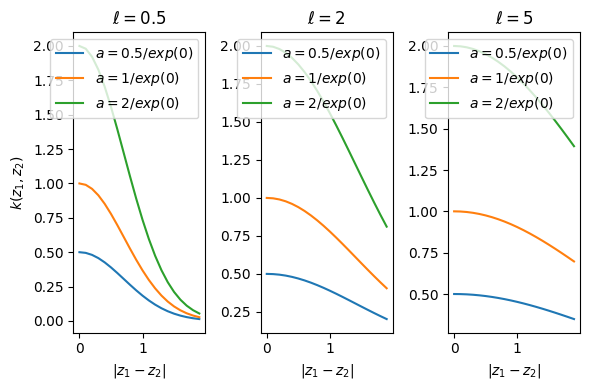

In [3]:
x = np.arange(0, 2, 0.1)
a = np.array([0.5/np.exp(0), 1/np.exp(0), 2/np.exp(0)])
ell = np.array([0.5, 2, 5])
ys = a[None, :, None] * np.exp(-x[None, None, :]**2/(2*ell[:, None, None]))

for i, title in enumerate([
    r"$\ell=0.5$",
    r"$\ell=2$",
    r"$\ell=5$"
]):
    plt.subplot(1, 3, i+1)
    plt.title(title)
    plt.xlabel(r"$|z_1 - z_2|$")
    if i == 0:
        plt.ylabel(r"$k(z_1,z_2)$")
    for j, label in enumerate([
        r"$a=0.5/exp(0)$",
        r"$a=1/exp(0)$",
        r"$a=2/exp(0)$"
    ]):
        plt.plot(x, ys[i][j], label=label)
    plt.legend(loc=1)
plt.tight_layout()
plt.show()

The selected kernel function depends on a ''distance" between the random variables at hand. In the notes, and early in this recitation we talked about the example of two cities, and the kernel function depends on the distance between the physical location of the two cities. In this case, each random variable represents the temeperature on a day, so the distance between two random variables can be understood as the distance between the "location" between these random variables. Of couse, this distance is in the time variable. For example we can consider the distance between two of these random variables as 1, representing a day. At this moment we do not care too much about the units, as the appropriate value for will incorporate the normalizing constant.


### Partition the observed data for cross validation

We will use the described cross validaton process. Where we are going to partition the available observations $\mathbf{x}_2$ into $\kappa$ partitions. For simplicity lets initially pick $\kappa=2$ that is, we partition $\mathbf{x}_2$ into two groups.


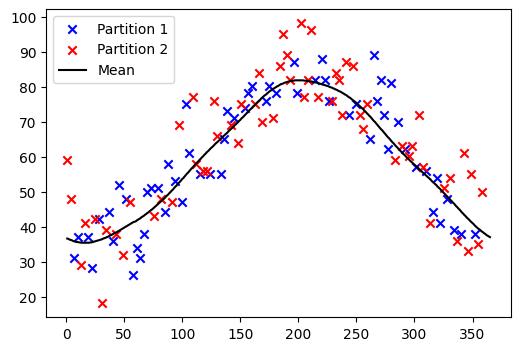

In [4]:
ind_x2 = np.arange(0, 360, 3)
perm = np.random.permutation(ind_x2.shape[0])
k1_x2, k2_x2 = [ind_x2[a] for a in map(np.sort, np.split(perm, 2))]

for k_x2, label, c in [(k1_x2, "Partition 1", 'b'), (k2_x2, "Partition 2", 'r')]:
    plt.scatter(k_x2+1, data[0][k_x2], label=label, c=c, marker='x')

x = np.arange(1, 366)
plt.plot(x, data[2], c='k', label="Mean")
plt.legend()
plt.show()

### The Conditional Distribution of Partition 1 given Partition 2

Here we are going to build a function that computes the conditional mean and variance of the random variables in Partition 1 given the data in Partition 2.


In [9]:
theta1 = 9.7  # @param {type:"slider", min:0.1, max:10, step:0.1}
theta2 = 0.4  # @param {type:"slider", min:0.1, max:10, step:0.1}
theta3 = 0.97  # @param {type:"slider", min:0, max:4, step:0.01}

covs = np.arange(1, 366)[:, None] - np.arange(1, 366)[None, :]

sigma = theta1 * np.exp(- covs**2 / theta2**2)

array([[   0,   -1,   -2, ..., -362, -363, -364],
       [   1,    0,   -1, ..., -361, -362, -363],
       [   2,    1,    0, ..., -360, -361, -362],
       ...,
       [ 362,  361,  360, ...,    0,   -1,   -2],
       [ 363,  362,  361, ...,    1,    0,   -1],
       [ 364,  363,  362, ...,    2,    1,    0]])

Now, we separate each of the components of the Covariance matrix

$$
\begin{equation}
\Sigma = \begin{bmatrix} \Sigma*{11} & \Sigma*{12} \\ \Sigma*{21} & \Sigma*{22} \end{bmatrix}
\end{equation}
$$

- $\Sigma_{11}$: Covariance of the Partition 1 entries
- $\Sigma_{12}$: Cross Covariance of the Partition 1 and 2 entries
- $\Sigma_{22}$: Covariance of the Partition 2 entries


In [22]:
sigma_11 = sigma[k1_x2[:, None], k1_x2]
sigma_12 = sigma[k1_x2[:, None], k2_x2]
sigma_21 = sigma[k2_x2[:, None], k1_x2]
sigma_22 = sigma[k2_x2[:, None], k2_x2]

mu_1 = data[2, k1_x2]
mu_2 = data[2, k2_x2]

It is time to compute the conditional mean and conditional variance

\begin{align}
\mu*{\mathbf{X}\_2^i | \mathbf{X}\_2^{-i}} &= \mu_2^i + \Sigma*{\mathbf{X}_2^i,\mathbf{X}\_2^{-i}} \Sigma_{\mathbf{X}_2^{-i},\mathbf{X}\_2^{-i}}^{-1} (\mathbf{x}\_2^{-i} - \mu_2^{-i}) \\
\Sigma_{\mathbf{X}_2^i,\mathbf{X}\_2^i|-i} &= \Sigma_{\mathbf{X}_2^i,\mathbf{X}\_2^i} - \Sigma_{\mathbf{X}_2^i,\mathbf{X}\_2^{-i}} \Sigma_{\mathbf{X}_2^{-i},\mathbf{X}\_2^{-i}}^{-1} \Sigma_{\mathbf{X}\_2^{-i},\mathbf{X}\_2^i}
\end{align}

Recall that we denote $\mu^{-i}$ as the information of all the data minus the partition $i$. Thus, for $i=1$ the term indicates the mean of the Partition 1 conditioned on the information from Partition 2.


In [23]:
import numpy.linalg as lalg


sigma_22_noise = sigma_22 + theta3 * np.eye(mu_2.shape[0])
x2_2 = data[0, k2_x2]

mu_1_2 = mu_1 + sigma_12.dot(lalg.solve(sigma_22_noise, x2_2-mu_2))
mu_2_2 = mu_2 + sigma_22.dot(lalg.solve(sigma_22_noise, x2_2-mu_2))

sigma_1_2 = sigma_11 - sigma_12.dot(lalg.inv(sigma_22_noise).dot(sigma_12.T))
sigma_2_2 = sigma_22 - sigma_22.dot(lalg.inv(sigma_22_noise).dot(sigma_22.T))

We have computed the conditional distributions of the Partition 1 given Partition 2. Let's see how this looks like


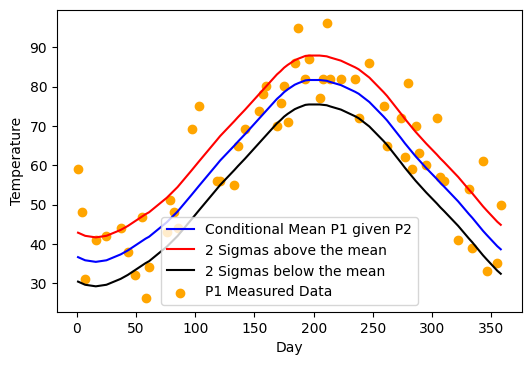

In [24]:
plt.plot(k1_x2+1, mu_1_2, c='b', label="Conditional Mean P1 given P2")
plt.scatter(k1_x2+1, data[0, k1_x2], c='orange',
            marker='o', label="P1 Measured Data")

plt.xlabel("Day")
plt.ylabel("Temperature")

sigma_diags = np.diagonal(sigma_1_2)
plt.plot(k1_x2+1, mu_1_2 + 2*np.sqrt(sigma_diags),
         c='r', label="2 Sigmas above the mean")
plt.plot(k1_x2+1, mu_1_2 - 2*np.sqrt(sigma_diags),
         c='k', label="2 Sigmas below the mean")

plt.legend()
plt.show()

### A Plot of the Conditional Distributions


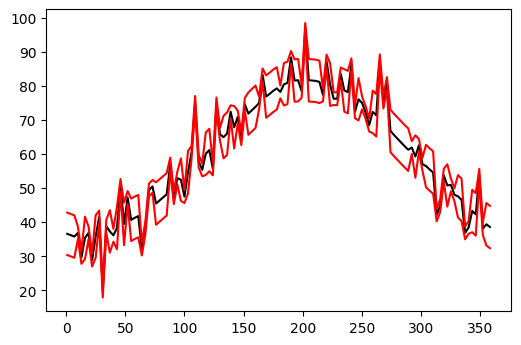

In [25]:
nu_mu = np.zeros(360)
nu_mu[k1_x2] = mu_1_2
nu_mu[k2_x2] = mu_2_2

new_sigma_diags = np.zeros(360)
new_sigma_diags[k1_x2] = sigma_diags
new_sigma_diags[k2_x2] = np.diagonal(sigma_2_2)

plt.plot(ind_x2+1, nu_mu[::3], c='k')
plt.plot(ind_x2+1, (nu_mu + 2*np.sqrt(new_sigma_diags))[::3], c='r')
plt.plot(ind_x2+1, (nu_mu - 2*np.sqrt(new_sigma_diags))[::3], c='r')
plt.show()

### Evaluating the Performance

Once the conditional mean and conditional variance have been computed for a particular set of parameters, the next step is to evaluate the performance of those parameters. Again, there is several options once can choose from as a merit function for the parameter selected.

Let's select as merit function the log marginal likelihood. In this case, a set of parameters that generate larger values, will indicate better peformance.

We define the log marginal likelihood of the partition $\mathbf{X}_2^i$ given $\mathbf{X}_2^{-i}$ as
\begin{align}
\log p\left( \mathbf{X}_2^{i} \mid \mathbf{X}\_2^{-i},\theta \right)  
 =& \log \left( \frac{1}{(2\pi)^{((N-d)/k)/2} |\Sigma_{\mathbf{X}_2^{i}|\mathbf{X}\_2^{-i}} |^{1/2}} \exp \left(-\frac{1}{2}( \mathbf{X}\_2^{i}-\mathbf{\mu}_{\mathbf{X}_2^{i}|\mathbf{X}\_2^{-i}} )^T\Sigma_{\mathbf{X}_2^{i}|\mathbf{X}\_2^{-i}} ^{-1}( \mathbf{X}\_2^{i}-\mathbf{\mu}_{\mathbf{X}_2^{i}|\mathbf{X}\_2^{-i}} )\right) \right)\\
=& -\log \left( (2\pi)^{((N-d)/k)/2} |\Sigma_{\mathbf{X}_2^{i}|\mathbf{X}\_2^{-i}} |^{1/2} \right) -\frac{1}{2}(\mathbf{X}\_2^{i}-\mathbf{\mu}_{\mathbf{X}_2^{i}|\mathbf{X}\_2^{-i}})^T\Sigma^{-1}(\mathbf{X}\_2^{i}-\mathbf{\mu}_{\mathbf{X}\_2^{i}|\mathbf{X}\_2^{-i}}),
\end{align}

Thus, the total merit can be computed as the summation for each of the partition $i$ as
\begin{equation}
\sum*{i=1}^k \log p\left( \mathbf{X}\_2^{i} \mid \mathbf{X}\_2^{-i},\theta \right).
\end{equation}
Formally, the optimization problem to be solved in order to find a "good" set of parameters is
\begin{equation}
\max*\theta \sum\_{i=1}^k \log p\left( \mathbf{X}\_2^{i} \mid \mathbf{X}\_2^{-i},\theta \right).
\end{equation}


## A running example for finding a "good" set of parameters

Initially, we need to set the search space

### Define Search Space

We have defined the set of parameters for the selected kernel function $\theta=(a,l)$ in this particular recitation, we will follow a brute force approach where we are going to test the performance of a number of values and select the one with the better performance.There are more sophisticated ways to select the parameter, such as gradient-based approaches. Feel free to explore those in your homework!

For simplicity, we are going to explore


In [33]:
a_vals = np.arange(70, 90, 0.1)
ell_vals = np.arange(2, 4, 0.01)

Now lets see how this works


100%|██████████| 200/200 [13:41<00:00,  4.11s/it]


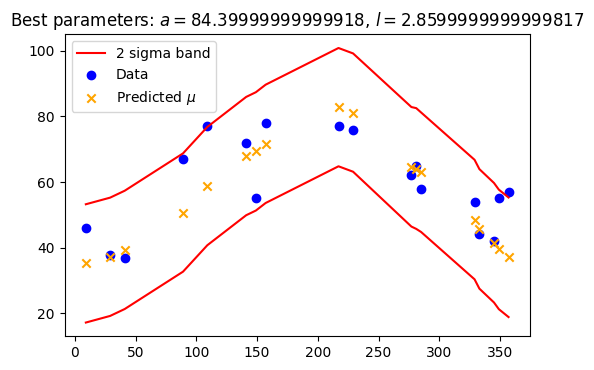

In [34]:
import scipy.stats
import tqdm

ind_x2 = np.arange(0, 360, 4)

K = 5
perm = np.random.permutation(ind_x2.shape[0])
ks_x2 = [ind_x2[a] for a in map(np.sort, np.array_split(perm, K))]

tau = 1.0

target_best = -np.inf
params_best = {}

for a_param in tqdm.tqdm(a_vals):
    for ell_param in ell_vals:
        sigma = a_param * np.exp(- covs**2 / ell_param**2)

        vals = []

        for k in range(K):
            x_test = ks_x2[k]
            x_train = np.sort(np.array(list(set(ind_x2) - set(x_test))))

            mu_1 = data[2, x_test]
            mu_2 = data[2, x_train]

            sigma_11 = sigma[x_test[:, None], x_test]
            sigma_12 = sigma[x_test[:, None], x_train]
            sigma_21 = sigma[x_train[:, None], x_test]
            sigma_22 = sigma[x_train[:, None], x_train]

            sigma_22_noise = sigma_22 + tau * np.eye(mu_2.shape[0])
            x2_2 = data[0, x_train]

            mu_1_2 = mu_1 + \
                sigma_12.dot(lalg.solve(sigma_22_noise, x2_2 - mu_2))
            sigma_1_2 = sigma_11 - \
                sigma_12.dot(lalg.inv(sigma_22_noise).dot(sigma_12.T))

            val = scipy.stats.multivariate_normal.logpdf(
                data[0, x_test], mean=mu_1_2, cov=sigma_1_2)
            vals.append(val)

        total = sum(vals)

        if total > target_best:
            params_best = dict(
                a=a_param,
                ell=ell_param,
                xs=x_test+1,
                data=data[0, x_test],
                mu=mu_1_2,
                sigma=np.sqrt(np.diagonal(sigma_1_2))
            )
            target_best = total

sigma_opt = params_best['a'] * np.exp(- covs**2 / params_best['ell']**2)
plt.scatter(params_best['xs'], params_best['data'],
            c='b', marker='o', label="Data")
plt.scatter(params_best['xs'], params_best['mu'],
            c='orange', marker='x', label=r"Predicted $\mu$")
plt.plot(params_best['xs'], params_best['mu'] + 2 *
         params_best['sigma'], c='r', label="2 sigma band")
plt.plot(params_best['xs'], params_best['mu'] - 2*params_best['sigma'], c='r')
plt.title(r"Best parameters: $a={a}$, $l={ell}$".format(**params_best))
plt.legend()
plt.show()

Recall that we have chosen the kernel function:

\begin{equation}
k(z_1,z_2) = a \times \exp{\left(- \frac{\| z_1 - z_2 \|}{2 l^2}\right)}.
\end{equation}


## Generating an estimate for the unobserved random variables.

Now that we have a set of "good" parameters for our kernel function, we can generate an estimate for the unobserved temperatures.

First we separate the components of the Covariance matrix witht the optimal parameters.


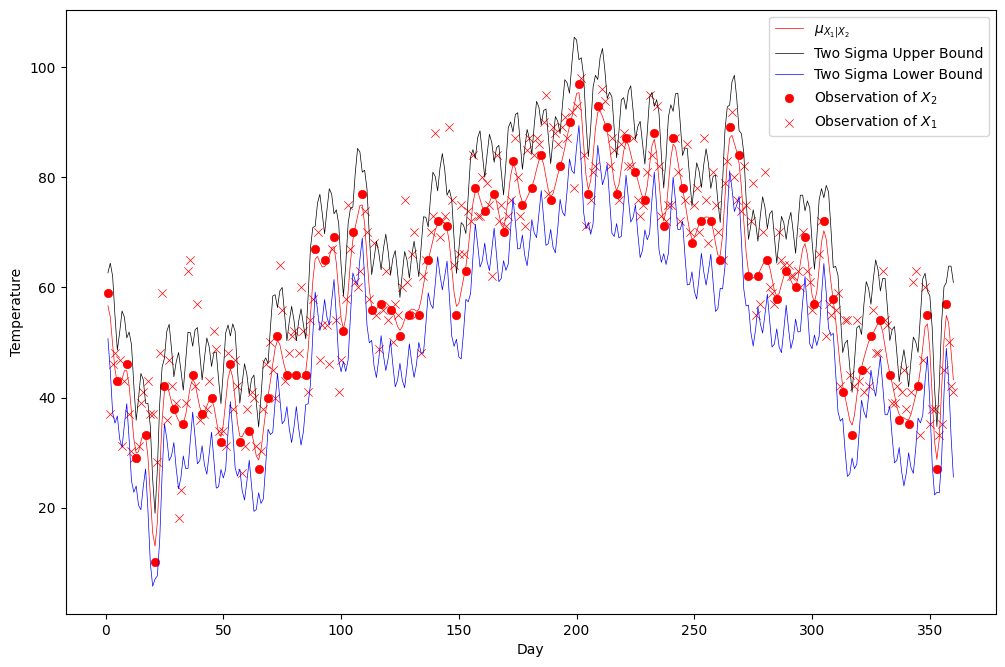

In [32]:
ind_x1 = np.array(sorted(list(set(np.arange(0, 360)) - set(ind_x2))))

# First  separate the components of the covariance matrix
sigma_11_n = sigma_opt[ind_x1[:, None], ind_x1]
sigma_12_n = sigma_opt[ind_x1[:, None], ind_x2]
sigma_21_n = sigma_opt[ind_x2[:, None], ind_x1]
sigma_22_n = sigma_opt[ind_x2[:, None], ind_x2]

mu_x1 = data[2, ind_x1]
mu_x2 = data[2, ind_x2]

tau = 10.0

sigma_22_n_noise = sigma_22_n + tau * np.eye(mu_x2.shape[0])
x2 = data[0, ind_x2]

mu_x1_n = mu_x1 + sigma_12_n.dot(lalg.solve(sigma_22_n_noise, x2 - mu_x2))
mu_x2_n = mu_x2 + sigma_22_n.dot(lalg.solve(sigma_22_n_noise, x2 - mu_x2))

sigma_x1_n = sigma_11_n - \
    sigma_12_n.dot(lalg.inv(sigma_22_n_noise).dot(sigma_12_n.T))
sigma_x2_n = sigma_22_n - \
    sigma_22_n.dot(lalg.inv(sigma_22_n_noise).dot(sigma_22_n.T))

new_mu = np.zeros(360)
new_mu[ind_x1] = mu_x1_n
new_mu[ind_x2] = mu_x2_n

new_sigma = np.zeros(360)
new_sigma[ind_x1] = np.sqrt(np.diagonal(sigma_x1_n))
new_sigma[ind_x2] = np.sqrt(np.diagonal(sigma_x2_n))

xs = np.arange(1, 361)
plt.figure(figsize=(12, 8))
plt.plot(xs, new_mu, c='r', label=r"$\mu_{X_1 | X_2}$", lw=0.5)
plt.plot(xs, new_mu + 2*new_sigma, c='k',
         label="Two Sigma Upper Bound", lw=0.5)
plt.plot(xs, new_mu - 2*new_sigma, c='b',
         label="Two Sigma Lower Bound", lw=0.5)
plt.scatter(ind_x2+1, data[0, ind_x2], c='r',
            marker='o', label="Observation of $X_2$", lw=0.5)
plt.scatter(ind_x1+1, data[0, ind_x1], c='r',
            marker='x', label="Observation of $X_1$", lw=0.5)
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend()
plt.show()